# 1. Setting up the enviroment

## Imports

In [1]:
%load_ext autoreload
%autoreload 1

import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import librosa as librosa
import librosa.display as display

import IPython.display as ipd
from IPython.display import SVG

import numpy as np
from numpy import savetxt

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout, Reshape, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, load_model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model, model_to_dot
from keras.backend import clear_session


%aimport SMCutils
su = SMCutils

Using TensorFlow backend.


## Global variables

In [2]:
#sampling rate
sr         = 22050

#freqs 
fmin       = 20
fmax       = sr / 2 

#number of samples. 
#for music it is recommended 2048, but with 4096 we are getting better results
n_fft      = 4096

#columns so we can get 256 frames 
hop_length = 690
n_frames   = 128*2

#rows to get nice 128 x 128 spectrograms 
n_mels     = 128

#filename prefix
prefix             = "spec"

#folder where the spectrograms are stored
spectrogram_folder = 'data/output/spectrograms/'

# 2. Read the spectrograms

In [3]:
file_list = su.get_file_list(spectrogram_folder, extension='png')
mel_spectrogram_array = su.get_spectrogram_array(file_list, n_mels, n_frames, 
                                                 spectrogram_folder, prefix, from_file_list=True)

21800/21825 spectrograms processed


# 3. Train the network

## Hyperparameters

In [4]:
code_dim       = 1024
epochs         = 400
batch_size     = 128
learning_rate  = 0.001
optimizer      = Adam(learning_rate=learning_rate)
loss           = 'mse'
act_layer      = 'relu'
act_last_layer = 'sigmoid'

## Output

In [5]:
version       = '03e'
explanation   = 'codedim1024_smallerconv'

model_name    = '20kconv_{}_{}_{}.json'.format(code_dim,version,explanation)
weights_name  = '20kconv_{}_{}_{}.h5'.format(code_dim,version,explanation)
filtered_name = '20kconv_{}_{}_{}.csv'.format(code_dim,version,explanation)
image_name    = '20kconv_{}_{}_{}.png'.format(code_dim,version,explanation)
enc_img_name  = '20kconv_{}_{}_{}_enc.png'.format(code_dim,version,explanation)
dec_img_name  = '20kconv_{}_{}_{}_dec.png'.format(code_dim,version,explanation)
wav_name      = '20kconv_{}_{}_{}_dec.wav'.format(code_dim,version,explanation)
inc_wav_name  = '20kconv_{}_{}_{}_inc.wav'.format(code_dim,version,explanation)

## Datasets

In [6]:
print(mel_spectrogram_array.shape[0], " spectrograms shape: (", n_mels, ",", n_frames, ")", sep='')
print ("Mel - Min:", np.amin(mel_spectrogram_array), "Max:", np.amax(mel_spectrogram_array))

x_train, x_test = su.split_dataset(mel_spectrogram_array, percentage_train=0.80)

print(len(x_train), "for training,", len(x_test), "for testing")

21825 spectrograms shape: (128,256)
Mel - Min: 0.0 Max: 1.0
Train: [0,17460)
 Test: [17460,21825)
17460 for training, 4365 for testing


## Topology

### Encoder

In [7]:
input_enc = Input(shape=(n_mels*n_frames,),name='input_enc')
encoded   = Reshape((n_mels, n_frames,-1),name='reshape')(input_enc)

encoded   = Conv2D(32, (3, 3), activation=act_layer, padding='same',name='conv32')(encoded)
encoded   = MaxPooling2D((2, 2), padding='same',name='maxpool64x128')(encoded)

encoded   = Conv2D(64, (3, 3), activation=act_layer, padding='same',name='conv64')(encoded)
encoded   = MaxPooling2D((2, 2), padding='same',name='maxpool32x64')(encoded)

encoded   = Conv2D(128, (3, 3), activation=act_layer, padding='same',name='conv128')(encoded)
encoded   = MaxPooling2D((2, 2), padding='same',name='maxpool16x32')(encoded)

encoded   = Conv2D(256, (3, 3), activation=act_layer, padding='same',name='conv256')(encoded)
encoded   = MaxPooling2D((2, 2), padding='same',name='maxpool8x16')(encoded)

encoded   = Flatten(name='flatten')(encoded)
encoded   = Dense(code_dim, activation=act_layer,name='code')(encoded)

encoder   = Model(input_enc, encoded, name='encoder')
encoder.summary()

# #plot_model(encoder, to_file=enc_img_name)
# #SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_enc (InputLayer)       (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 256, 1)       0         
_________________________________________________________________
conv32 (Conv2D)              (None, 128, 256, 32)      320       
_________________________________________________________________
maxpool64x128 (MaxPooling2D) (None, 64, 128, 32)       0         
_________________________________________________________________
conv64 (Conv2D)              (None, 64, 128, 64)       18496     
_________________________________________________________________
maxpool32x64 (MaxPooling2D)  (None, 32, 64, 64)        0         
_________________________________________________________________
conv128 (Conv2D)             (None, 32, 64, 128)       7385

### Decoder

In [8]:
input_dec = Input(shape=(code_dim,),name='input_dec')
decoded   = Dense(n_mels*n_frames, activation=act_last_layer, name='output')(input_dec)

decoder   = Model(input_dec, decoded, name='decoder')
decoder.summary()

#plot_model(decoder, to_file=dec_img_name)
#SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_dec (InputLayer)       (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 32768)             33587200  
Total params: 33,587,200
Trainable params: 33,587,200
Non-trainable params: 0
_________________________________________________________________


### Full model

In [9]:
output_dec  = decoder(encoder(input_enc))
autoencoder = Model(input_enc,output_dec, name='autoencoder')

autoencoder.compile(optimizer=optimizer, loss=loss)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_enc (InputLayer)       (None, 32768)             0         
_________________________________________________________________
encoder (Model)              (None, 1024)              33943296  
_________________________________________________________________
decoder (Model)              (None, 32768)             33587200  
Total params: 67,530,496
Trainable params: 67,530,496
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
import time
start_time = time.time()

checkpoint = ModelCheckpoint('incremental\best_'+weights_name, monitor='loss', verbose=1, 
                             save_best_only=True, mode='auto', period=10, save_weights_only=True)

history = autoencoder.fit(x_train, x_train,
               epochs = epochs,
               batch_size = batch_size,
               validation_data=(x_test, x_test),
               verbose=1,
               callbacks=[checkpoint])

print("--- %s seconds ---" % (time.time() - start_time))

Train on 17460 samples, validate on 4365 samples
Epoch 1/400


In [ ]:
plt.figure(figsize=[15,6])

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(image_name)

## Alternative trainings
### Incremental
Generates a wav file at different points of the training, to understand how the neural network is learning.

In [ ]:
#Safeguard to avoid accidental retraining

raise SystemExit("Stop right there!")

In [ ]:
#Generates a wav file at different points of the training, to 
#understand how the neural network is learning.

# element = 45
# for index in range(0,20):

#     history = autoencoder.fit(x_train, x_train, 
#                     epochs = 5,
#                     batch_size = batch_size,
#                     validation_data=(x_test, x_test),
#                     verbose=1)

#     code = encoder.predict(np.reshape(x_train[element],(1,-1)))
#     decoded_data = decoder.predict(code)

#     _, y_ae = su.spectrogram_to_audio(decoded_data, n_mels, n_frames, sr, n_fft, hop_length, fmin, fmax)
    
#     librosa.output.write_wav('incremental/{}_{}_{}.wav'.format(inc_wav_name, index*10, history.history['loss'][-1]), 
#                              y_ae, sr, norm=True)
    
# import zipfile
# zipf = zipfile.ZipFile('incremental_data.zip', 'w', zipfile.ZIP_DEFLATED)
# for root, dirs, files in os.walk('incremental'):
#         for file in files:
#             zipf.write(os.path.join(root, file))

# zipf.close()

### Dataset tunning
Train the NN for 100 epochs to check learning vs. overfitting

In [ ]:
#Safeguard to avoid accidental retraining

raise SystemExit("Stop right there!")

In [ ]:
#import time

#initial_weights = autoencoder.get_weights()

#for value in [2000,6000,10000,14000,18000,21825]:
#    x_train, x_test = su.split_dataset(mel_spectrogram_array, percentage_train=0.80, max_elements=value)

#    autoencoder.set_weights(initial_weights)

#    start_time = time.time()
#    history = autoencoder.fit(x_train, x_train,
#                epochs = 100,
#                batch_size = batch_size,
#               validation_data=(x_test, x_test),
#                verbose=1)
#    print("{:.3f} seconds".format(time.time() - start_time))
#    print("     loss: {:.5f}".format(history.history['loss'][-1]))
#    print("val. loss: {:.5f}".format(history.history['val_loss'][-1]))
#    print()
          
#raise SystemExit("Stop right there!")

## Save everything

### Save the model

In [ ]:
# Commented to avoid accidental overwriting. Uncomment if you want to save the model.

# model_json = autoencoder.to_json()
# with open(model_name, "w") as json_file:
#     json_file.write(model_json)

### Save the weights

In [ ]:
# Commented to avoid accidental overwriting. Uncomment if you want to save the weights.

# autoencoder.save_weights(weights_name)

### Code values

In [ ]:
# entries_to_keep = [9, 13, 14, 22, 23, 26, 27, 28, 32, 34, 35, 38, 49, 84,
# 97, 98, 99, 100, 101, 104, 105, 113, 117, 121, 146, 148, 160, 167,
# 168, 169, 176, 181, 183, 184, 193, 194, 209, 210, 211, 212, 213, 214,
# 215, 216, 217, 218, 219, 251, 257, 264, 268, 269, 271, 272, 273, 280,
# 281, 290, 293, 297, 306, 307, 308, 312, 314, 334, 338, 339, 340, 343,
# 344, 345, 346, 347, 348, 349, 350, 352, 357, 360, 362, 363, 366, 367,
# 368, 369, 370, 371, 372, 380, 388, 389, 397, 398, 425, 436, 437, 438,
# 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
# 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,
# 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
# 481, 482, 483, 484, 485, 486, 487, 488, 491, 492, 493, 494, 495, 496,
# 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510,
# 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524,
# 527, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 546, 547, 549,
# 550, 566, 576, 577, 578, 579, 580, 581, 586, 587, 588, 590, 591, 604,
# 605, 616, 618, 621, 631, 632, 638, 639, 641, 642, 648, 651, 652, 653,
# 656, 675, 676, 683, 685, 686, 692, 697, 698, 699, 700, 701, 702, 703,
# 709, 710, 711, 712, 713, 714, 715, 717, 718, 719, 720, 721, 722, 730,
# 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 742, 743, 744, 746,
# 748, 754, 755, 756, 757, 758, 759, 760, 787, 823, 824, 851, 853, 868,
# 879, 880, 881, 882, 883, 884, 885, 886, 887, 896, 897, 898, 899, 900,
# 903, 904, 905, 908, 909, 910, 911, 913, 914, 916, 917, 939, 940, 943,
# 944, 945, 946, 947, 948, 949, 950, 952, 953, 954, 955, 958, 961, 962,
# 965, 966, 967, 976, 980, 981, 982, 983, 986, 987, 988, 989, 990, 991,
# 992, 994, 998, 999, 1000, 1004, 1005, 1006, 1007, 1008, 1011, 1017, 1018, 1023,
# 1024, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1038, 1041, 1042, 1043,
# 1044, 1045, 1046, 1047, 1048, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061,
# 1062, 1065, 1068, 1069, 1070, 1071, 1073, 1074, 1077, 1080, 1081, 1082, 1083, 1084,
# 1086, 1089, 1093, 1094, 1098, 1099, 1105, 1106, 1109, 1113, 1114, 1115, 1116, 1117,
# 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1129, 1132, 1135, 1138, 1139,
# 1142, 1145, 1150, 1151, 1152, 1155, 1158, 1159, 1161, 1165, 1170, 1171, 1172, 1175,
# 1178, 1179, 1181, 1182, 1183, 1184, 1185, 1188, 1192, 1193, 1194, 1195, 1197, 1202,
# 1205, 1206, 1207, 1208, 1211, 1212, 1216, 1220, 1224, 1226, 1227, 1229, 1230, 1231,
# 1232, 1241, 1242, 1245, 1247, 1248, 1251, 1252, 1253, 1256, 1259, 1261, 1262, 1264,
# 1267, 1270, 1274, 1275, 1276, 1277, 1278, 1279, 1282, 1285, 1286, 1287, 1288, 1289,
# 1290, 1291, 1292, 1293, 1296, 1300, 1302, 1303, 1304, 1305, 1308, 1312, 1313, 1314,
# 1315, 1317, 1318, 1320, 1321, 1323, 1324, 1327, 1331, 1332, 1334, 1335, 1336, 1337,
# 1338, 1346, 1347, 1348, 1351, 1352, 1353, 1354, 1356, 1357, 1358, 1359, 1364, 1365,
# 1366, 1367, 1368, 1369, 1370, 1371, 1376, 1378, 1379, 1386, 1387, 1389, 1390, 1391,
# 1392, 1393, 1394, 1397, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1410,
# 1413, 1414, 1415, 1416, 1417, 1422, 1427, 1430, 1431, 1438, 1440, 1441, 1442, 1451, 
# 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1463, 1465, 1469, 1474, 1477, 1478, 1480, 
# 1481, 1485, 1492, 1497, 1499, 1500, 1501, 1502, 1503, 1505, 1506, 1507, 1508, 1509, 
# 1512, 1519, 1523, 1524, 1531, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 
# 1543, 1544, 1545, 1547, 1550, 1553, 1554, 1558, 1559, 1560, 1564, 1569, 1572, 1573, 
# 1574, 1575, 1576, 1577, 1578, 1579, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 
# 1593, 1596, 1599, 1600, 1602, 1603, 1604, 1605, 1620, 1623, 1626, 1627, 1628, 1629, 
# 1630, 1631, 1632, 1637, 1638, 1642, 1644, 1653, 1654, 1655, 1656, 1657, 1660, 1663, 
# 1664, 1666, 1667, 1668, 1669, 1672, 1675, 1679, 1681, 1682, 1684, 1685, 1686, 1687, 
# 1690, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1704, 1706, 1708, 1709, 
# 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1724, 
# 1725, 1726, 1727, 1734, 1744, 1747, 1748, 1762, 1769, 1770, 1774, 1775, 1778, 1779, 
# 1780, 1781, 1782, 1783, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1795, 1796,
# 1797, 1798, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1813, 1814, 1815, 1816, 
# 1817, 1818, 1819, 1820, 1821, 1822, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1835,
# 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1856, 1859, 1880, 1884, 1885,
# 1889, 1890, 1891, 1893, 1894, 1895, 1897, 1903, 1904, 1906, 1907, 1908, 1909, 1912,
# 1915, 1918, 1919, 1923, 1924, 1927, 1928, 1941, 1942, 1943, 1944, 1947, 1948, 1949,
# 1950, 1951, 1952, 1953, 1954, 1958, 1984, 1985, 1986, 1991, 1992, 1993, 1994, 1995,
# 1996, 1997, 1998, 2000, 2001, 2007, 2012, 2015, 2016, 2018, 2019, 2020, 2025, 2033, 
# 2040, 2044, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2056, 2057, 2058, 2060,
# 2061, 2062, 2066, 2067, 2069, 2072, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
# 2082, 2083, 2084, 2085, 2086, 2089, 2090, 2091, 2092, 2093, 2096, 2100, 2101, 2102, 
# 2107, 2110, 2112, 2115, 2118, 2119, 2120, 2121, 2122, 2125, 2127, 2128, 2129, 2130,
# 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2147, 2148, 2149,
# 2150, 2153, 2156, 2168, 2169, 2170, 2171, 2172, 2173, 2176, 2177, 2178, 2182, 2183,
# 2184, 2185, 2186, 2187, 2188, 2190, 2192, 2197, 2198, 2201, 2203, 2207, 2210, 2213,
# 2214, 2215, 2218, 2220, 2221, 2226, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236,
# 2237, 2239, 2240, 2241, 2243, 2244, 2248, 2252, 2253, 2255, 2256, 2257, 2258, 2259,
# 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2268, 2269, 2285, 2288, 2290, 2291, 2300,
# 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2310, 2311, 2313, 2314, 2315, 2317,
# 2319, 2320, 2321, 2324, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2340, 2348, 2349, 
# 2350, 2353, 2354, 2359, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2372, 2374, 2375,
# 2377, 2378, 2379, 2382, 2390, 2391, 2396, 2398, 2403, 2404, 2406, 2408, 2409, 2410,
# 2411, 2412, 2413, 2414, 2419, 2420, 2422, 2423, 2424, 2428, 2429, 2430, 2434, 2437,
# 2440, 2443, 2444, 2445, 2453, 2460, 2463, 2475, 2486, 2487, 2488, 2492, 2493, 2494, 
# 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2506, 2507, 2508, 2509,
# 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523,
# 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2535, 2537, 2538, 2540,
# 2541, 2542, 2543, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2556, 2557, 2558, 2559, 
# 2560, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2599, 2600, 2601, 2602, 
# 2603, 2604, 2605, 2606, 2607, 2610, 2612, 2613, 2637, 2638, 2639, 2640, 2641, 2642,
# 2643, 2644, 2655, 2677, 2680, 2681, 2682, 2683, 2702, 2703, 2704, 2705, 2706, 2710,
# 2711, 2712, 2713, 2714, 2715, 2727, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736,
# 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2750, 2751,
# 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762]

# spectrograms_filtered = []
# for i in entries_to_keep:
#     spectrograms_filtered.append(mel_spectrogram_array[i])

# spectrograms_filtered = np.reshape(spectrograms_filtered,(len(spectrograms_filtered),-1))
    
# code_filtered = encoder.predict(spectrograms_filtered)
# code_filtered = np.reshape(code_filtered,(-1,code_dim))
# savetxt(filtered_name, code_filtered, delimiter=',')

# 4. Use the network

## Load architecture and weights

In [7]:
model_name   = '20kconv.json'
weights_name = '20kconv.h5'

json_file = open(model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)
autoencoder.load_weights(weights_name)
autoencoder.compile(loss=loss, optimizer=optimizer)

In [8]:
autoencoder.evaluate(x_train, x_train)

17460/17460 [==============================] - 12s 713us/step


0.001893205820787634

In [9]:
autoencoder.evaluate(x_test, x_test)

4365/4365 [==============================] - 3s 600us/step


0.003184466122170614

## Split the network into encoder and decoder

In [10]:
encoder = autoencoder.get_layer('encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      (None, 32768)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 128, 256, 1)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 256, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 128, 32)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 128, 64)       18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 64, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 64, 128)       7385

In [11]:
decoder = autoencoder.get_layer('decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             33587200  
Total params: 33,587,200
Trainable params: 33,587,200
Non-trainable params: 0
_________________________________________________________________


## Reconstruct a wav from the test set

In [12]:
x = x_test
element = np.random.randint(0,len(x))
#element = 45
#element = 4421
#element = 15723
print("Clip num.", element)

code = encoder.predict(np.reshape(x[element],(1,-1)))
print ("X - Min:", np.amin(code), "Max:", np.amax(code))

noise = np.random.normal(0, np.amax(code)/12, [1,code_dim]) 
#code = code+noise
decoded_data = decoder.predict(code)

Clip num. 1315
X - Min: 0.0 Max: 5.5974417


## Recover audio from original and reconstructed spectrograms

In [13]:
mel_orig, y_orig = su.spectrogram_to_audio(x[element],n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)
mel_ae, y_ae = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

## Check everything is OK

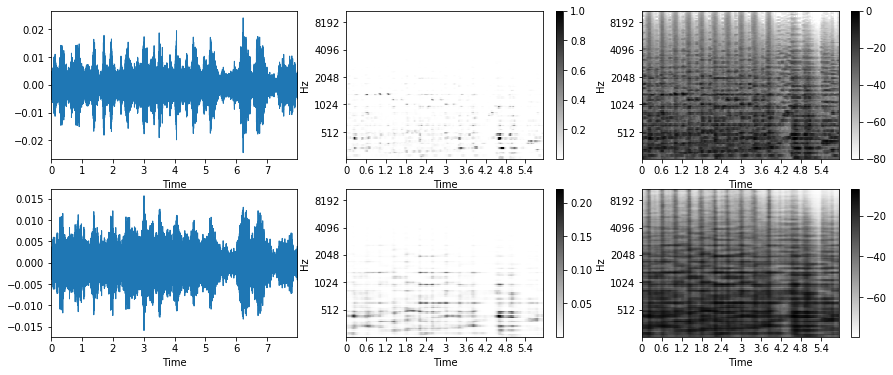

In [14]:
plt.figure(figsize=[15,6])

plt.subplot(2, 3, 1)
librosa.display.waveplot(y_orig);

plt.subplot(2, 3, 4)
librosa.display.waveplot(y_ae);

plt.subplot(2, 3, 2)
librosa.display.specshow(mel_orig, x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
plt.colorbar()

plt.subplot(2, 3, 5)
librosa.display.specshow(mel_ae, x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
plt.colorbar()

plt.subplot(2, 3, 3)
librosa.display.specshow(librosa.power_to_db(mel_orig), x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
plt.colorbar()

plt.subplot(2, 3, 6)
librosa.display.specshow(librosa.power_to_db(mel_ae), x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
plt.colorbar()

In [15]:
ipd.Audio(y_orig, rate=sr)

In [16]:
ipd.Audio(y_ae, rate=sr)

In [17]:
librosa.output.write_wav(wav_name, y_ae, sr, norm=True)

## Visualize the activations of the first convolutional layer

In [18]:
layer_outputs = [layer.output for layer in encoder.layers[:3]] 
layer_input = encoder.get_input_at(0)

activation_model = Model(inputs=layer_input, outputs=layer_outputs)

activations = activation_model.predict(np.reshape(x[element],(1,-1)))

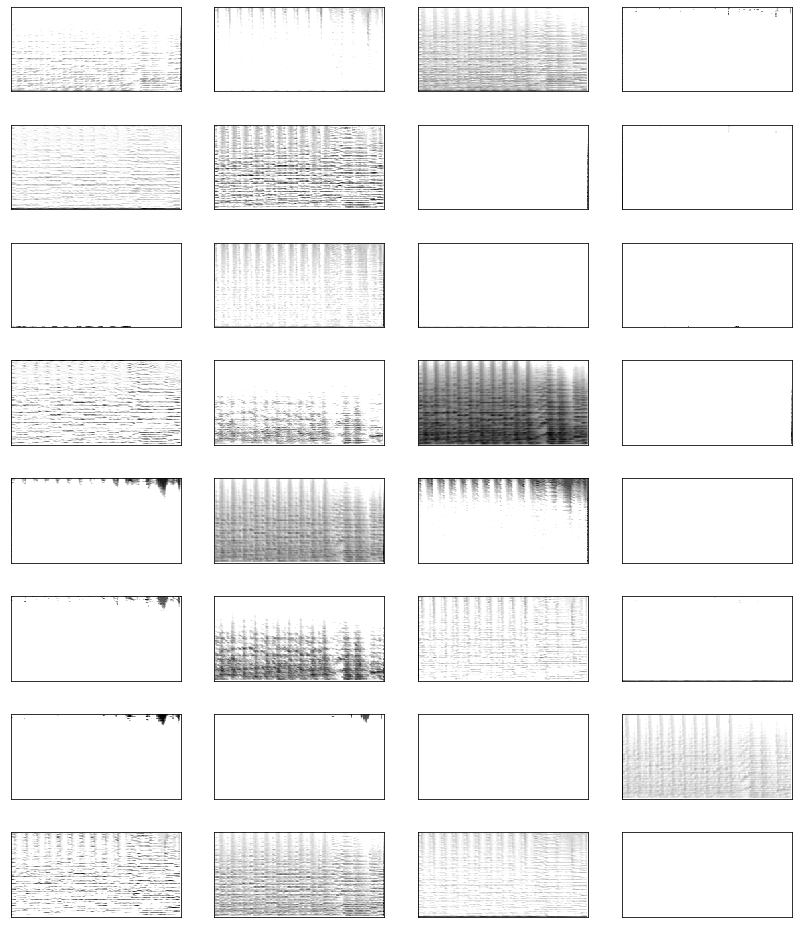

In [19]:
fig = plt.figure(figsize=[14,17])
for f in range(0,32):
    plt.subplot(8, 4, f+1)
    fig = plt.imshow(activations[2][0,:,:,f], cmap='binary', origin='lower')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)